In [17]:
#Reservoir simulation example. 1D, Oil phase only and homogeneous
library(ggplot2)
library(reshape2)

In [18]:
#Input Data
nx <- 50   #number of cells
beta <- 0.001127  #convertion factor
alpha <- 5.614  #convertion factor

dx <- 100 #ft, dimension in x direction
dy <- 1000 #ft, dimension in y direction
dz <- 75 #ft, dimension in z direction

poro <- 0.18 #porosity, fraction
Cr <- 0 #rock Compressibility psi^-1
Cf <- 0.0000035 #fluid Compressibility  psi^-1
k <- 15 #permeability, md
Bo <- 1 #Formation volume factor, RB/STB
vis <- 2 #viscosity,cp 

#Well information
rw <- 3.5 #in, well radius
s <- 0 #skin
cellP <- 25 #well cell
qo <- -150 #well rate, STB/D

dt <- 1 #time step, days
TT <- 100 #total simulation time, days

Po <- 6000 #psi, Initial condition

In [19]:
#Previus calculations
Ax <- dy * dz #Faces area
vol <- dx * dy * dz #Cells volume
TE <- ((beta * Ax * k) / (vis * Bo * dx))  #  East transmisibility
TW <- ((beta * Ax * k) / (vis * Bo * dx))  #  West transmisibility

Acum <- ((vol * poro * (Cf + Cr)) / (alpha * Bo * dt))
time <- dt
Pt <- rep(Po, nx) #Pressure at time n
Ptdt <- rep(0, nx) #Pressure at time n + 1 

#geometry factor
req <- 0.14 * ((dx) **2 + (dy) ** 2) ** 0.5
FG <- (2 * 3.1416 * beta * k * dz) / (log(req / (rw / 12)) + s)

#Results data.frame
results_cells <- data.frame(0, t(Pt))
colnames(results_cells) <- c("Time", 1:nx)
cells_x <- seq(dx/2, (dx*nx)-(dx/2), length.out = nx)

results_pwf <- data.frame(Time = numeric(), Pwf = numeric())

In [20]:
#Thomas functions for tridiagonal matrix
thomas <- function(a,b,c,d,x,n){
  # Subroutine to solve a tridiagonal system
  # a = subdiagonal vector
  # B = diagonal vector
  # c = superdiagonal vector
  # d = right hand side vector
  # x = solution vector
  # n = number of diagonal vector elements 
  
  #Forward elimination
  for(i in 2:n){
    b[i] <- b[i]-a[i]*c[i-1]/b[i-1]
    d[i] <- d[i]-a[i]*d[i-1]/b[i-1]
  }
  
  #Back substitution
  x[n] <- d[n]/b[n]
  for(i in (nx-1):1){
    x[i] <- (d[i]-c[i]*x[i+1])/b[i]
  }
  
  return(x)
  
}

In [21]:
#Time loop
while( time <= TT ){
  
  aa <- rep(TW, nx)
  bb <- rep(-(TW + TE + Acum), nx)
  cc <- rep(TE, nx)
  dd <- rep(-Acum, nx)*Pt
  
  #Boundary condition, No flow
  #West
  bb[1] <- -(TE + Acum)
  #East
  bb[nx] <- -(TW + Acum)
  
  #Well
  dd[cellP] = dd[cellP] - qo
  
  Ptdt <- thomas(aa,bb,cc,dd,Ptdt,nx)
  
  Pt <- Ptdt
  
  pwf = qo / (FG / (Bo * vis)) + Pt[cellP]
  results_cells <- rbind(results_cells, c(time,Ptdt))
  results_pwf <-rbind(results_pwf, c(time, pwf))
  time = time + dt
}

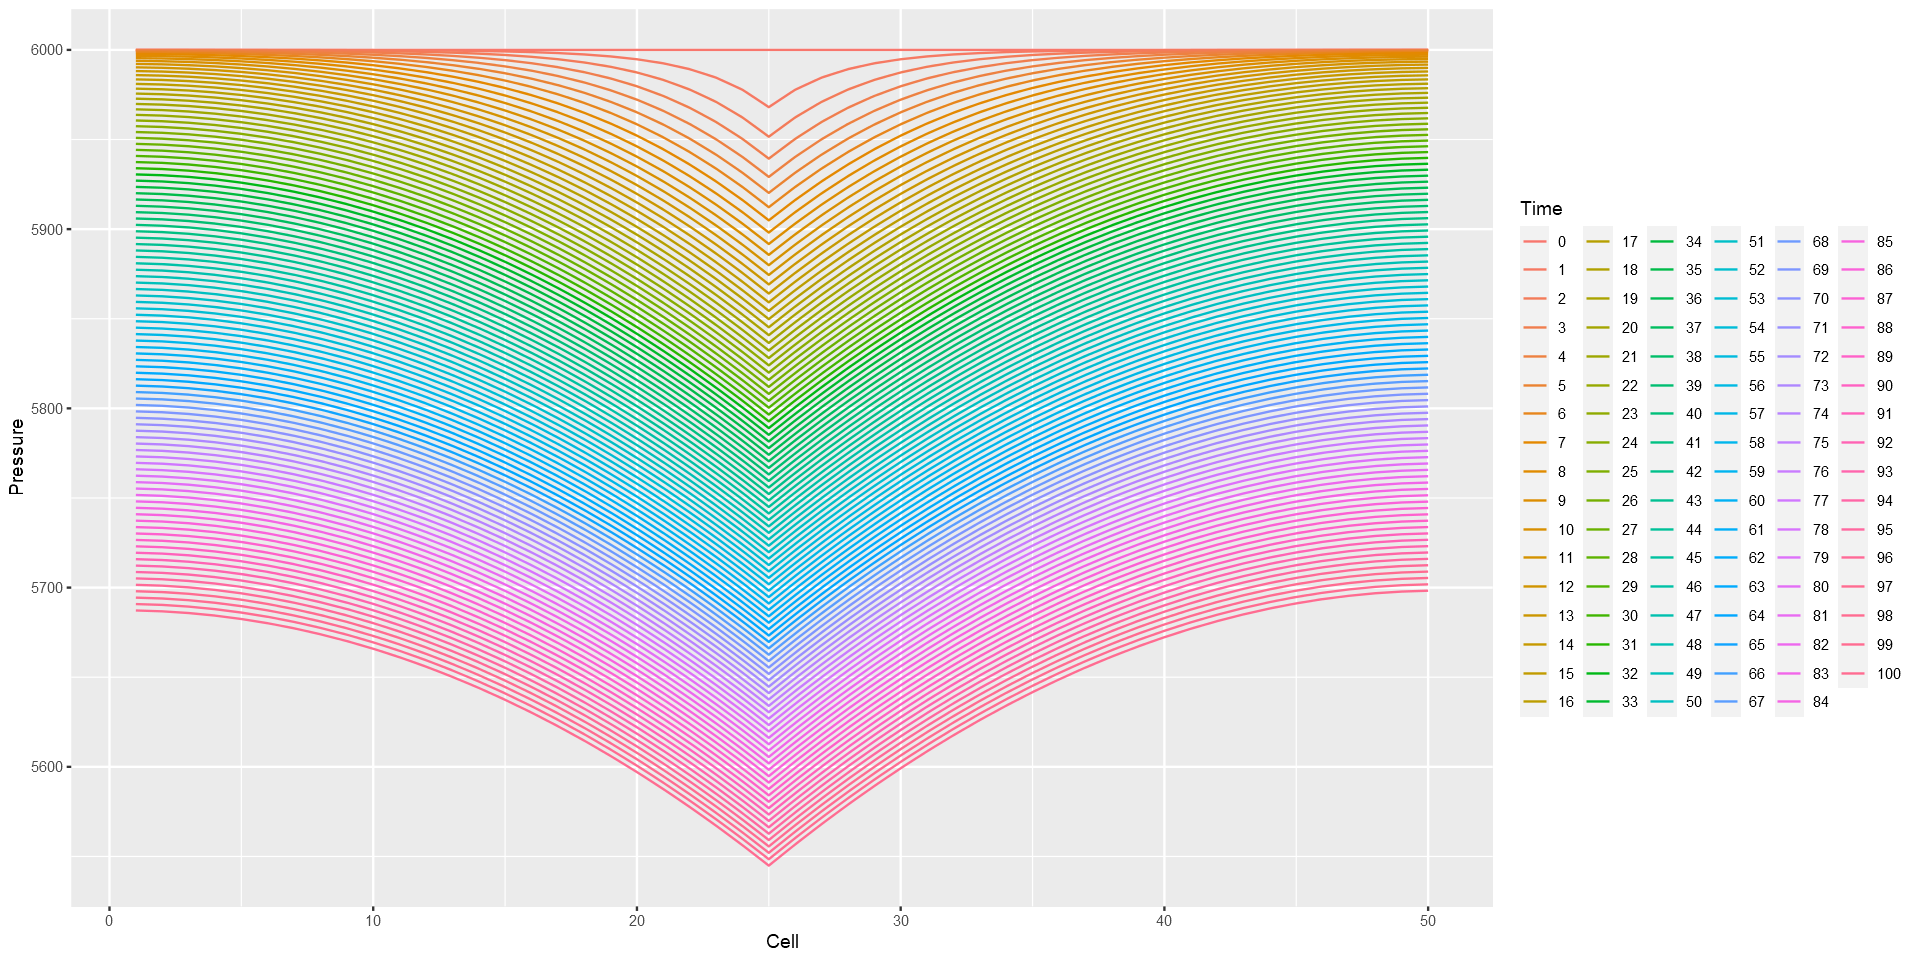

In [23]:
#Plot
options(repr.plot.width=16, repr.plot.height=8)
results_cells_time <-reshape2::melt(results_cells,id.vars=c("Time"))
colnames(results_cells_time) <- c("Time", "Cell", "Pressure")
results_cells_time$Time <- as.factor(results_cells_time$Time)
results_cells_time$Cell <- as.numeric(results_cells_time$Cell)
ggplot(results_cells_time, aes(Cell, Pressure, color = Time)) + 
      geom_line()

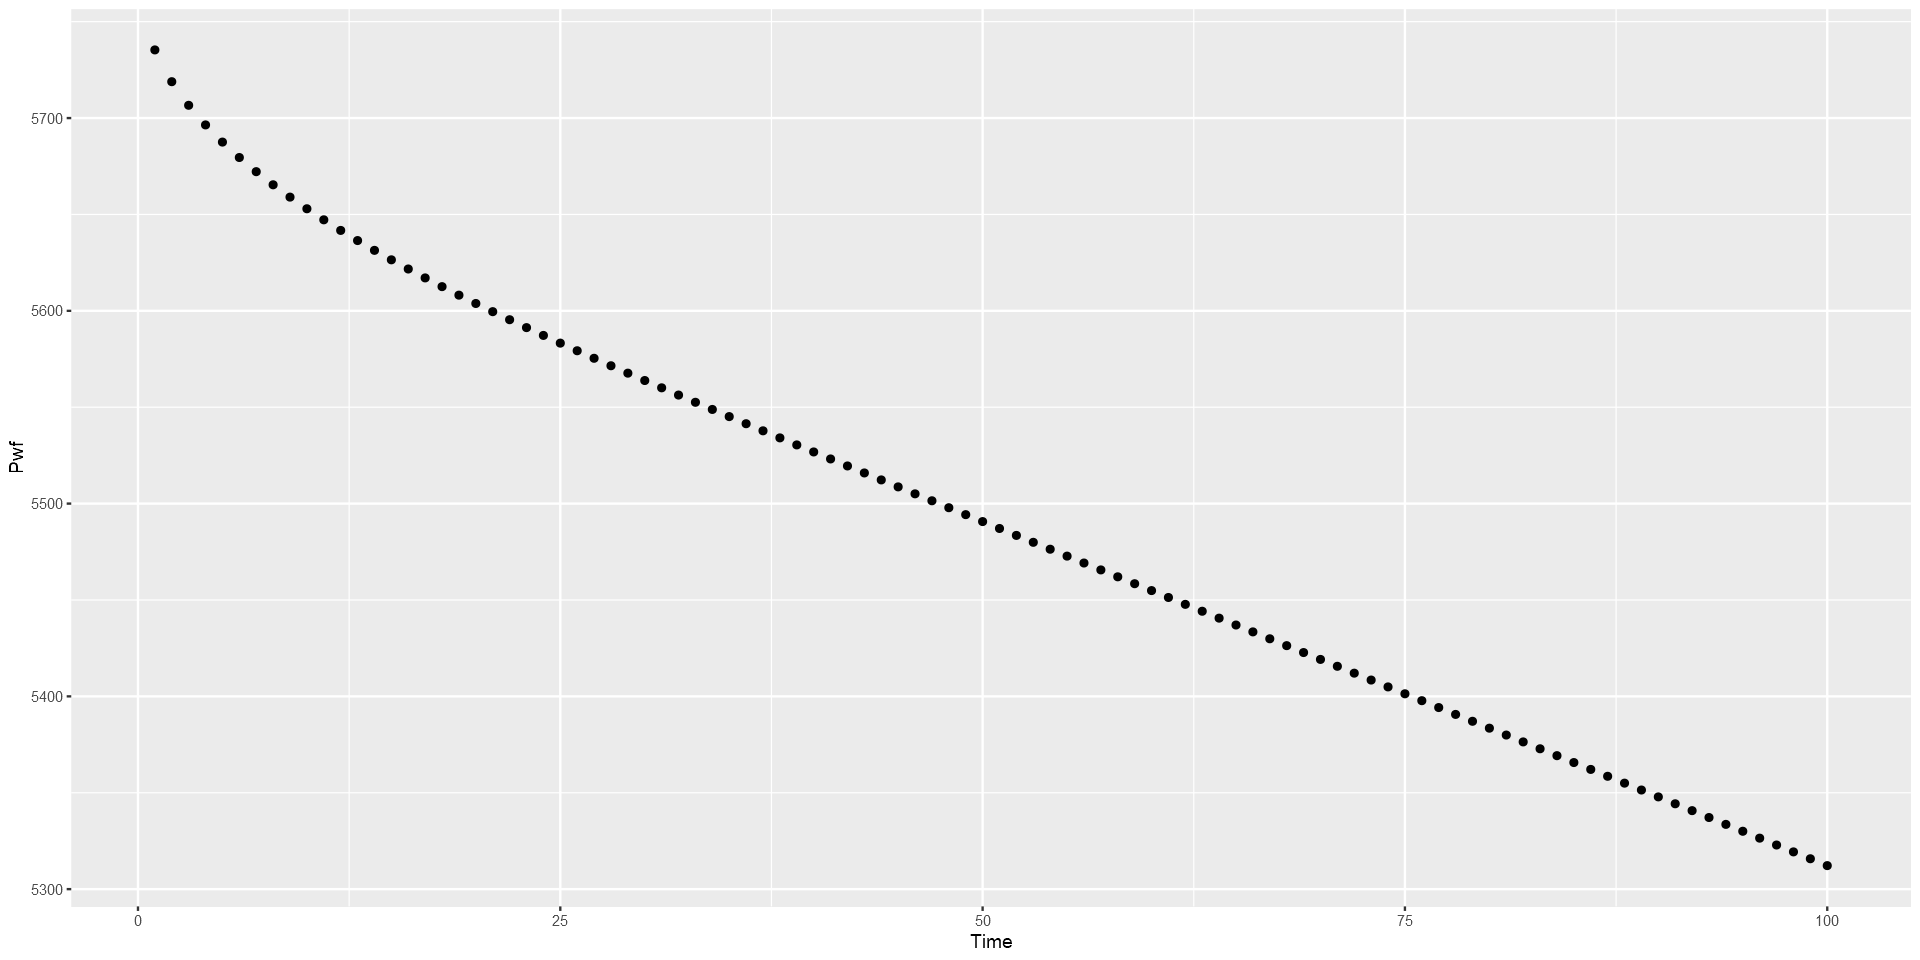

In [24]:
colnames(results_pwf) <-c("Time", "Pwf")
ggplot(results_pwf, aes(Time, Pwf)) + 
  geom_point()

In [22]:
print(results_cells)

    Time        1        2        3        4        5        6        7
1      0 6000.000 6000.000 6000.000 6000.000 6000.000 6000.000 6000.000
2      1 5999.991 5999.990 5999.987 5999.983 5999.976 5999.967 5999.953
3      2 5999.947 5999.941 5999.928 5999.908 5999.878 5999.835 5999.774
4      3 5999.826 5999.810 5999.776 5999.723 5999.645 5999.535 5999.386
5      4 5999.582 5999.549 5999.482 5999.376 5999.224 5999.016 5998.739
6      5 5999.171 5999.116 5999.004 5998.829 5998.581 5998.247 5997.812
7      6 5998.561 5998.480 5998.315 5998.058 5997.699 5997.222 5996.610
8      7 5997.732 5997.622 5997.399 5997.053 5996.574 5995.946 5995.148
9      8 5996.676 5996.536 5996.252 5995.815 5995.214 5994.432 5993.449
10     9 5995.393 5995.223 5994.878 5994.351 5993.630 5992.698 5991.536
11    10 5993.891 5993.691 5993.288 5992.675 5991.838 5990.764 5989.433
12    11 5992.181 5991.954 5991.496 5990.800 5989.855 5988.647 5987.158
13    12 5990.277 5990.024 5989.515 5988.743 5987.698 5986.367 5